# Experiments with CIFAR-100 Dataset and Attentive Gate MoE Training

The experiments in this notebook include training the attentive gate MoE models as follows:

1. attentive gate MoE without regularization.
2. attentive gate MoE with $L_{importance}$ regularization.
3. attentive gate MoE with $L_s$ regularization.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy
from itertools import product

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

/nobackup/projects/bdrap03/yamuna/miniconda/envs/mnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")
print('device', device)

device cuda:1


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models/hidden_256'
results_path = '../results'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)

In [7]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4,padding_mode="reflect"),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

In [8]:
cifar100_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
cifar100_testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
cifar100_testset, cifar100_trainset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR100
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5074, 0.4867, 0.4411), std=(0.2011, 0.1987, 0.2025))
            ),
 Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                ToTensor()
                Normalize(mean=(0.5074, 0.4867, 0.4411), std=(0.2011, 0.1987, 0.2025))
            ))

In [9]:
num_classes = 100

In [10]:
trainsize = 50000
testsize = 10000

In [11]:
batch_size = 256

In [12]:
cifar100_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar100_trainset, range(trainsize)), batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)
cifar100_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar100_testset, range(testsize)), batch_size=batch_size,
                                         shuffle=True, num_workers=4, pin_memory=True)

In [13]:
import csv
with open('data/cifar100_class_names.txt','r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    classes_cifar100 = []
    for row in csvreader:
        if row:
            classes_cifar100.append(row[1])

classes_cifar100            

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [14]:
coarse_labels_cifar100 = OrderedDict()
reverse_coarse_labels_cifar100 = {}
with open('data/cifar100_coarse_labels.txt','r') as fp:
    for line in fp:
        items = line.strip().split('\t')
        coarse_labels_cifar100[items[0]] = items[1]
        for item in items[1].split(','):
            reverse_coarse_labels_cifar100[item.strip()] = items[0]
coarse_labels_cifar100.keys()
reverse_coarse_labels_cifar100

{'beaver': 'aquatic mammals',
 'dolphin': 'aquatic mammals',
 'otter': 'aquatic mammals',
 'seal': 'aquatic mammals',
 'whale': 'aquatic mammals',
 'aquarium_fish': 'fish',
 'flatfish': 'fish',
 'ray': 'fish',
 'shark': 'fish',
 'trout': 'fish',
 'orchid': 'flowers',
 'poppy': 'flowers',
 'rose': 'flowers',
 'sunflower': 'flowers',
 'tulip': 'flowers',
 'bottle': 'food container',
 'bowl': 'food container',
 'can': 'food container',
 'cup': 'food container',
 'plate': 'food container',
 'apple': 'fruit and vegetables',
 'mushroom': 'fruit and vegetables',
 'orange': 'fruit and vegetables',
 'pear': 'fruit and vegetables',
 'sweet_pepper': 'fruit and vegetables',
 'clock': 'household electrical devices',
 'keyboard': 'household electrical devices',
 'lamp': 'household electrical devices',
 'telephone': 'household electrical devices',
 'television': 'household electrical devices',
 'bed': 'household furniture',
 'chair': 'household furniture',
 'couch': 'household furniture',
 'table': '

In [15]:
#Function to display the images
def plot_colour_images(images_to_plot, titles=None, nrows=None, ncols=6, thefigsize=(18,18)):
    # images_to_plot: list of images to be displayed
    # titles: list of titles corresponding to the images
    # ncols: The number of images per row to display. The number of rows 
    #        is computed from the number of images to display and the ncols
    # theFigsize: The size of the layour of all the displayed images
    
    n_images = images_to_plot.shape[0]
    
    # Compute the number of rows
    if nrows is None:
        nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()
    
    for i in range(n_images):
        img = images_to_plot[i,:,:,:]
        npimg = np.clip(img.numpy(),0,1)
        ax[i].imshow(npimg) 
        ax[i].axis('off')  
        if titles is not None and i<10:
            ax[i].set_title(titles[i%10])

In [16]:
# # get some random training images
# dataiter = iter(cifar100_trainloader)
# images, labels = dataiter.next()
# print(images.shape, np.unique(labels))

# images_to_plot = []
# count = 0
# selected_labels = []
# for i in range(100):
#     if count == 10:
#         break
#     index = np.where(labels==i)[0]
#     if len(index) >= 3:
#         selected_labels.append(i)
#         images_to_plot.append(images[index[0:3],:,:])
#         count += 1
    
# selected_labels = [classes_cifar100[i] for i in selected_labels]
# images_to_plot = torch.transpose(torch.stack(images_to_plot),0,1)
# new_shape = images_to_plot.shape
# images_to_plot = images_to_plot.reshape(new_shape[0]*new_shape[1], new_shape[2], new_shape[3], new_shape[4])
# images_to_plot = images_to_plot.permute(0,2,3,1)
# plot_colour_images(images_to_plot, nrows=3, ncols=10,thefigsize=(20,6), titles=selected_labels)

## Define expert and gate networks

In [17]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=3):
        super(expert_layers, self).__init__()
        filter_size = 3
        self.filters = 16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2,1024)
        self.fc2 = nn.Linear(1024, 256)
        
        self.out = nn.Linear(in_features=256, out_features=num_classes)
                        
    def forward(self, x):
        # conv 1        
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))    
    
        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn8(self.conv4(x))))
        
        x = x.reshape(-1, self.filters*8*2*2)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        self.hidden = x
        
        x = F.relu(x)
        
        x = self.out(x)
        
        # output
        x = F.softmax(x, dim=1)

        return x    


In [18]:
class gate_attn_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_attn_layers, self).__init__()
        # define layers
       # define layers
        filter_size = 3
        self.filters = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2, 1024)
        self.fc2 = nn.Linear(1024, 256)
                 
    def forward(self, x, T=1.0, y=None):
        # conv 1
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))

        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn8(self.conv4(x))))
        
        x = x.reshape(-1, self.filters*8*2*2)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [19]:
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        filter_size = 3
        self.filters = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2, 1024)
        self.fc2 = nn.Linear(1024, 256)
        
        self.out = nn.Linear(in_features=256, out_features=num_experts)
        
    def forward(self, x, T=1.0, y=None):
        # conv 1        
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))

        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn8(self.conv4(x))))
        
        x = x.reshape(-1, self.filters*8*2*2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.out(x)
        x = F.softmax(x/T, dim=1)
        return x


In [20]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [21]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Functions to train models

### Function to train attentive gate model with and without regularization

* w_importance_range is the range of values for the $w_{importance}$ hyperparameter of the $L_{importance}$ regularization.
* w_sample_sim_same_range is the range of values for $\beta_s$ hyperparameter of the $L_s$ regularization.
* w_sample_sim_diff_range is the range of values for $\beta_d$ hyperparameter of the $L_s$ regularization.

In [22]:
def train_with_attention(model_1, trainloader, testloader, runs, temps=[[1.0]*20], 
                         w_importance_range=[0.0], w_sample_sim_same_range=[0.0], 
                         w_sample_sim_diff_range=[0.0], 
                         num_classes=10, total_experts=5, num_epochs=20):
    
    hidden = 256
    
    for T, w_importance, w_sample_sim_same, w_sample_sim_diff in product(temps, w_importance_range, w_sample_sim_same_range,  
                                                                         w_sample_sim_diff_range):                                                                       
        
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
        
        for run in range(1, runs+1):

            print('Run:', run)
            
            n_run_models_1 = []
            
            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes).to(device)
                
                gate_model = gate_attn_layers(total_experts).to(device)

                moe_model = val['model'](total_experts, num_classes, attention_flag=1, hidden=hidden, 
                                         experts=expert_models, gate=gate_model, device=device).to(device)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
                

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, w_importance=w_importance, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
            
            if os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
            n_run_models_1.append(models)
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
            

### Function to distill the attentive gate model to the original model

In [23]:
def train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=[0.0], 
                     w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                     trainloader=None, testloader=None, expert_no_grad=True, gate_no_grad=False):
    
    T = [1.0]*num_epochs
    for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
        
        plot_file = generate_plot_file(m, temp=T[0], w_importance=w_importance,  
                                       w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                       specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        attn_models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        n_run_models_1 = []
        for model in attn_models: 
            # Initialise the new expert weights to the weights of the experts of the trained attentive gate model.
            # Fix all the weights of the new experts so they are not trained. 

            new_expert_models = experts(total_experts, num_classes).to(device)
            old_expert_models = model['moe_expectation_model']['experts'][total_experts]['model'].experts
            for i, expert in enumerate(new_expert_models):
                old_expert = old_expert_models[i]
                expert.load_state_dict(old_expert.state_dict())
                if expert_no_grad:
                    for param in expert.parameters():
                        param.requires_grad = False

            new_gate_model = gate_layers(total_experts).to(device)
            old_gate_model = model['moe_expectation_model']['experts'][total_experts]['model'].gate
            new_gate_model.load_state_dict(old_gate_model.state_dict(), strict=False)

            if gate_no_grad:
                for param in new_gate_model.parameters():
                    param.requires_grad = False
                new_gate_model.out = nn.Linear(in_features=32, out_features=num_experts)
                
            gate_model = new_gate_model

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),
                                           'experts':{}},}

            for key, val in models.items():

                # gate_model = gate_layers(total_experts).to(device)                

                moe_model = val['model'](total_experts, num_classes,
                                         experts=new_expert_models, gate= gate_model, device=device).to(device)

                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)


                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            plot_file = generate_plot_file('new_'+m, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
        
            if os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
            n_run_models_1.append(models)                                
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
            print(plot_file)        


## Experiments

### Experiment 1: Attentive gate MoE model training

In [60]:
# Model with gate and expert parameters initialized to default values
model_1 = 'cifar100_with_attention'

In [61]:
total_experts = 20

In [62]:
num_epochs = 40

In [63]:
runs = 5

In [ ]:
train_with_attention(model_1, cifar100_trainloader, cifar100_testloader, runs, num_classes=num_classes, 
                 total_experts=total_experts, num_epochs=num_epochs)

### Experiment 2: Attentive gate MoE model training with $L_{importance}$ regularization

In [377]:
# Model with gate and expert parameters initialized to default values
model_2 = 'cifar100_with_attn_reg'

In [378]:
total_experts = 20

In [379]:
num_epochs = 40

In [55]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

w_importance_range =  ['0.2', '0.4', '0.6', '0.8', '1.0']


In [381]:
temps = [[1.0]*num_epochs]

In [382]:
runs = 5

In [383]:
train_with_attention(model_2, cifar100_trainloader, cifar100_testloader, runs, temps=temps, 
                     w_importance_range=w_importance_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.2
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 3.83 , training accuracy 0.13 , test accuracy 0.18
epoch 1 training loss 3.24 , training accuracy 0.23 , test accuracy 0.25
epoch 2 training loss 2.97 , training accuracy 0.28 , test accuracy 0.28
epoch 3 training loss 2.79 , training accuracy 0.32 , test accuracy 0.32
epoch 4 training loss 2.66 , training accuracy 0.34 , test accuracy 0.35
epoch 5 training loss 2.54 , training accuracy 0.37 , test accuracy 0.37
epoch 6 training loss 2.44 , training accuracy 0.39 , test accuracy 0.38
epoch 7 training loss 2.37 , training accuracy 0.41 , test accuracy 0.40
epoch 8 training loss 2.29 , training accuracy 0.42 , test accuracy 0.41
epoch 9 training loss 2.24 , training accuracy 0.44 , test accuracy 0.42
epoch 10 training loss 2.19 , training accuracy 0.45 , test accuracy 0.43
epoch 11 training loss 2.12 , training accuracy 0.47 , test accuracy 0.44
epoch 12 training loss 2.08 , training accuracy 0.47 ,

### Experiment 3: Attentive gate MoE model training with sample similarity $L_s$ regularization

In [368]:
# Model with gate and expert parameters initialized to default values
model_3 = 'cifar100_with_attn_reg'

In [369]:
total_experts = 20

In [370]:
num_epochs = 40

In [56]:
w_sample_sim_same_range = [1e-5,1e-4,1e-3]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

w_sample_sim_same_range =  [1e-05, 0.0001, 0.001]
w_sample_sim_diff_range =  [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


In [372]:
runs = 5

In [373]:
train_with_attention(model_3, cifar100_trainloader, cifar100_testloader, runs, temps, 
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.0001
w_sample_sim_diff 1e-06
Run: 1
epoch 0 training loss 3.89 , training accuracy 0.11 , test accuracy 0.15
epoch 1 training loss 3.31 , training accuracy 0.20 , test accuracy 0.22
epoch 2 training loss 3.04 , training accuracy 0.25 , test accuracy 0.27
epoch 3 training loss 2.86 , training accuracy 0.29 , test accuracy 0.29
epoch 4 training loss 2.73 , training accuracy 0.32 , test accuracy 0.33
epoch 5 training loss 2.62 , training accuracy 0.34 , test accuracy 0.33
epoch 6 training loss 2.53 , training accuracy 0.36 , test accuracy 0.36
epoch 7 training loss 2.45 , training accuracy 0.38 , test accuracy 0.37
epoch 8 training loss 2.38 , training accuracy 0.40 , test accuracy 0.39
epoch 9 training loss 2.33 , training accuracy 0.41 , test accuracy 0.40
epoch 10 training loss 2.27 , training accuracy 0.42 , test accuracy 0.41
epoch 11 training loss 2.22 , training accuracy 0.43 , test accuracy 0.41
epoch 12 training loss 2.18 , training accuracy 0

### Experiment 4: Distilling attentive gate MoE model

#### Distilling attentive gate MoE model with $L_{importance}$ regularization

In [ ]:
m = 'cifar100_with_attn_reg'

total_experts = 20
num_classes = 100
num_epochs = 40

w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=w_importance_range, 
                 trainloader=cifar100_trainloader, testloader=cifar100_testloader)

#### Distilling attentive gate MoE model with $L_{s}$ regularization

In [ ]:
m = 'cifar100_with_attn_reg'

total_experts = 20
num_classes = 100
num_epochs = 40

w_sample_sim_same_range = [1e-5,1e-4,1e-3]
w_sample_sim_diff_range = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

train_from_model(m, num_epochs, num_classes, total_experts,
                 w_sample_sim_same_range=w_sample_sim_same_range,
                 w_sample_sim_diff_range=w_sample_sim_diff_range,
                 trainloader=cifar100_trainloader, testloader=cifar100_testloader)

w_sample_sim_same_range =  [1e-05, 0.001]
w_sample_sim_diff_range =  [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
w_importance 0.0
w_sample_sim_same 1e-05
w_sample_sim_diff 1e-07
epoch 0 training loss 2.63 , training accuracy 0.36 , test accuracy 0.36
epoch 1 training loss 2.22 , training accuracy 0.43 , test accuracy 0.38
epoch 2 training loss 2.10 , training accuracy 0.45 , test accuracy 0.41
epoch 3 training loss 2.01 , training accuracy 0.47 , test accuracy 0.42
epoch 4 training loss 1.96 , training accuracy 0.48 , test accuracy 0.43
epoch 5 training loss 1.91 , training accuracy 0.50 , test accuracy 0.44
epoch 6 training loss 1.86 , training accuracy 0.51 , test accuracy 0.44
epoch 7 training loss 1.81 , training accuracy 0.52 , test accuracy 0.45
epoch 8 training loss 1.77 , training accuracy 0.53 , test accuracy 0.46
epoch 9 training loss 1.74 , training accuracy 0.53 , test accuracy 0.45
epoch 10 training loss 1.70 , training accuracy 0.54 , test accuracy 0.46
epoch 11 train

## Results

### Collect the train error, test error, mutual information $I(E;Y)$, sample entropy $H_s$ and expert usage entropy $H_u$ for all the models trained with CIFAR-100 dataset. Store the reuslts in the '../results/cifar100_results.csv' file.

In [24]:
pretrained_model_path = '../models/hidden_256'

In [25]:
results_file = 'cifar100_results_hidden_256.csv'

In [26]:
import sys
sys.path.append('../src')

In [27]:
# Compute accuracy of the model
def accuracy_top5(out, yb):
    preds = torch.argsort(out, dim=1,descending=True).to(device, non_blocking=True)
    N = preds.shape[0]
    correct = 0
    for i in range(N):
        # print(yb[i], preds[i,0:5], out[i, preds[i,0:5]])
        # print(out[i, preds[i,:]])
        if yb[i] in preds[i,0:5]:
            correct += 1
    return correct/N
    

In [28]:
import csv
from helper import moe_models

def collect_results(m, temps=[1.0], w_importance_range=[0.0], 
                    w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                    total_experts=5, num_classes=10, num_epochs=20, 
                    testloader=None, model_path=None, results_path=None, filename = results_file):
    
    filename = os.path.join(results_path, filename)
    
    if os.path.exists(filename):
        p = 'a'
    else:
        p = 'w'
        
    header = ['filename', 'train error', 'top-1 error', 'top-5 error', 'mutual information', 'sample entropy', 'experts usage']
    
    with open(filename, p) as f:
                
        writer = csv.writer(f)        
        
        if p == 'w':            
            writer.writerow(header)
        
        for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
            plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, 
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
            for _ in range(len(models)):
                mod = models.pop()
                data = [plot_file]
                # model
                model = mod['moe_expectation_model']['experts'][total_experts]['model']
                model.device = device
                # history
                history = mod['moe_expectation_model']['experts'][total_experts]['history']
                # train error
                data.append(1-history['accuracy'][-1].item())
                running_top1_accuracy = 0.0
                running_top5_accuracy = 0.0
                running_entropy = 0.0
                num_batches = 0
                ey =  torch.zeros((num_classes, total_experts)).to(device)
                for test_inputs, test_labels in testloader:
                    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
                    outputs = model(test_inputs)
                    
                    running_top1_accuracy += accuracy(outputs, test_labels)
                    running_top5_accuracy += accuracy_top5(outputs, test_labels)
                    
                    selected_experts = torch.argmax(model.gate_outputs, dim=1)
                    y = test_labels
                    e = selected_experts
                    for j in range(y.shape[0]):
                        ey[int(torch.argmax(model.expert_outputs[j,e[j],:])), int(e[j])] += 1

                    running_entropy += moe_models.entropy(model.gate_outputs)
                    
                    num_batches+=1
 
                mutual_EY,_,_,_ = moe_models.mutual_information(ey.detach())
    
                top1_error = 1-(running_top1_accuracy/num_batches)
                top5_error = 1-(running_top5_accuracy/num_batches)
                
                data.append(top1_error.item())
                data.append(top5_error)
                data.append(mutual_EY.item())
                
                data.append(running_entropy.item()/num_batches)  
                gate_probabilities_sum = torch.mean(model.gate_outputs, dim=0)            
                data.append(entropy(gate_probabilities_sum).item())
                
                writer.writerow(data)
            
            

In [28]:
total_experts = 20
num_classes = 100
num_epochs = 40

In [ ]:
m = 'cifar100_without_reg'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar100_testloader, model_path=pretrained_model_path, results_path=results_path)

In [58]:
m = 'cifar100_with_reg'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar100_testloader, model_path=pretrained_model_path, results_path=results_path)

In [59]:
m = 'cifar100_with_reg'
w_sample_sim_same_range = [1e-5, 1e-4, 1e-3]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar100_testloader, model_path=pretrained_model_path, results_path=results_path)

In [60]:
m = 'cifar100_with_attention'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar100_testloader, model_path=pretrained_model_path, results_path=results_path)

device cuda:0


In [61]:
m = 'cifar100_with_attn_reg'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar100_testloader, model_path=pretrained_model_path, results_path=results_path)

In [62]:
m = 'cifar100_with_attn_reg'
w_sample_sim_same_range = [1e-5,1e-4,1e-3]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar100_testloader, model_path=pretrained_model_path, results_path=results_path)

In [29]:
m = 'new_cifar100_with_attn_reg'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar100_testloader, model_path=pretrained_model_path, results_path=results_path)

device cuda:0
Files already downloaded and verified
Files already downloaded and verified


In [30]:
m = 'new_cifar100_with_attn_reg'
w_sample_sim_same_range = [1e-5, 1e-4,1e-3]
w_sample_sim_diff_range = [1e-7,1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar100_testloader, model_path=pretrained_model_path, results_path=results_path)

### Final results

#### These are the final performance results, reported in the paper, on the test data for the model with the minimum training error for each category of MoE model and training method.

In [30]:
import pandas as pd
filename = os.path.join(results_path, results_file)
data = pd.read_csv(filename)

In [31]:
final_results_filename = os.path.join(results_path,'cifar100_final_results_hidden_256.csv')

In [ ]:
models = ['cifar100_single_model', 'cifar100_without_reg', 'cifar100_with_reg_importance', 
          'cifar100_with_reg_sample', 'cifar100_with_attention', 'cifar100_with_attn_reg_importance',
          'cifar100_with_attn_reg_sample', 'new_cifar100_with_attn_reg_importance',
          'new_cifar100_with_attn_reg_sample'] 
header = True
for i, m in enumerate(models):
    model_data = data[data['filename'].str.startswith(m)]
    if model_data.empty:
        continue
    if i:
        header = False
    row = data.loc[[data[data['filename'].str.startswith(m)]['train error'].idxmin()]]
    # std = '{:.3f}'.format(data[data['filename'].str.startswith(m)]['test error'].std())
    # row['val error std'] = std
    row.to_csv(final_results_filename,mode='a',header=header, index=False, float_format='%.3f')

In [36]:
models = ['cifar100_single_model', 'cifar100_without_reg', 'cifar100_with_reg_importance', 
          'cifar100_with_reg_sample', 'cifar100_with_attention', 'cifar100_with_attn_reg_importance',
          'cifar100_with_attn_reg_sample', 'new_cifar100_with_attn_reg_importance',
          'new_cifar100_with_attn_reg_sample'] 
header = True
df = None
for i, m in enumerate(models):
    model_data = data[data['filename'].str.startswith(m)]
    if model_data.empty:
        continue
    if i:
        header = False
    series = model_data.mean(numeric_only=True)
    # print(model_data['filename'])
    # std = '{:.3f}'.format(data[data['filename'].str.startswith(m)]['test error'].std())
    # row['val error std'] = std
    row = pd.DataFrame([series.values], columns=series.index)
    row.insert(0, 'filename' , model_data['filename'].iloc[0])
    if df is None:
        df = row
    else:
        df = pd.concat([df, row])

header = ['filename', 'train error', 'top-1 error', 'top-5 error', 'mutual information', 'sample entropy', 'experts usage']
    
df.to_csv(final_results_filename,mode='a',header=header, index=False, float_format='%.3f')


In [32]:
models = ['cifar100_single_model', 'cifar100_without_reg', 'cifar100_with_reg_importance', 
          'cifar100_with_reg_sample', 'cifar100_with_attention', 'cifar100_with_attn_reg_importance',
          'cifar100_with_attn_reg_sample', 'new_cifar100_with_attn_reg_importance',
          'new_cifar100_with_attn_reg_sample'] 
# 'cifar100_single_model', 
header = True
df = None
# std = ['{:.3f}'.format(std_val) for std_val in data.groupby('filename')['test error'].std().values]
data = data.groupby('filename').mean().reset_index()
# data['val error std'] = std
for i, m in enumerate(models):
    model_data = data[data['filename'].str.startswith(m)]
    if model_data.empty:
        continue
    if i:
        header = False
    series = model_data.mean(numeric_only=True)
    row = pd.DataFrame([series.values], columns=series.index)
    row.insert(0, 'filename' , model_data['filename'].iloc[0])
    if df is None:
        df = row
    else:
        df = pd.concat([df, row])
header = ['filename', 'train error', 'top-1 error', 'top-5 error', 'mutual information', 'sample entropy', 'experts usage']
    
df.to_csv(final_results_filename,mode='a',header=header, index=False, float_format='%.3f')

In [33]:
data = pd.read_csv(final_results_filename)
data.fillna('NA', inplace=True)
data

,filename,train error,top-1 error,top-5 error,mutual information,sample entropy,experts usage
0,cifar100_single_model_0,0.402,0.468,0.179,NA,NA,NA
1,cifar100_without_reg_100_20_models.pt,0.412,0.470,0.180,0.99,0.409,1.204
2,cifar100_with_reg_importance_0.2_100_20_models.pt,0.423,0.492,0.197,4.202,1.497,3.97
3,cifar100_with_reg_sample_sim_same_0.0001_sampl...,0.414,0.482,0.190,2.416,0.801,2.43
4,cifar100_with_attention_100_20_models.pt,0.271,0.461,0.188,1.799,0.519,2.039
5,cifar100_with_attn_reg_importance_0.2_100_20_m...,0.271,0.447,0.188,3.652,1.114,3.855
6,cifar100_with_attn_reg_sample_sim_same_0.0001_...,0.287,0.460,0.187,1.748,0.526,2.022
7,new_cifar100_with_attn_reg_importance_0.2_100_...,0.619,0.685,0.350,2.117,2.969,4.125
8,new_cifar100_with_attn_reg_sample_sim_same_0.0...,0.421,0.549,0.251,0.918,1.232,1.986


In [24]:
total_experts = 20
pre_trained_model_path = model_path

In [25]:
import sys
sys.path.append('../src')

In [26]:
def plot_coarse_label_conf_tab(m, w_importance=0, w_sample_sim_same=0, w_sample_sim_diff=0):
    
    plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,
                                   w_sample_sim_diff=w_sample_sim_diff, 
                                   specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    models = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
    min_train_error = float('inf')
    best_model = models[0]
    for i, model in enumerate(models):
        train_error = 1-model['moe_expectation_model']['experts'][total_experts]['history']['accuracy'][-1]
        if train_error < min_train_error:
            min_train_error = train_error
            best_model = model
    true_labels = []
    pred_labels = []
    true_coarse_labels = []
    pred_coarse_labels = []
    selected_experts = []
    
    model = best_model['moe_expectation_model']['experts'][total_experts]['model']
    model.device = device
    for test_inputs, test_labels in cifar100_testloader:
        test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
        outputs = model(test_inputs)
        gate_outputs = model.gate_outputs
        true_labels += test_labels
        pred_labels += torch.argmax(outputs, dim=1)
        selected_experts += torch.argmax(gate_outputs, dim=1)

    true_labels = torch.stack(true_labels)
    pred_labels = torch.stack(pred_labels)
    selected_experts = torch.stack(selected_experts)
    
    for true_label, pred_label in zip(true_labels,pred_labels):
        coarse_label_name = reverse_coarse_labels_cifar100[classes_cifar100[true_label]]
        coarse_label = list(coarse_labels_cifar100.keys()).index(coarse_label_name)
        true_coarse_labels.append(coarse_label)

        coarse_label_name = reverse_coarse_labels_cifar100[classes_cifar100[pred_label]]
        coarse_label = list(coarse_labels_cifar100.keys()).index(coarse_label_name)
        pred_coarse_labels.append(coarse_label)   
        
    coarse_expert_table = np.asarray([[0] * 20]*total_experts)
    for label, expert in zip(true_coarse_labels, selected_experts):
        coarse_expert_table[expert,label] += 1

    fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10, 8))
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
    sns.heatmap(coarse_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                xticklabels=[list(coarse_labels_cifar100.keys())[i] for i in range(0, 20)],
                annot=True, cmap=cmap, fmt='d', ax=ax)

    plt.title('Experts selected per digit for '+str(len(cifar100_testloader))+' samples of\n MNIST test data', 
                  fontsize=12)


In [32]:
m = 'cifar100_with_reg'
plot_coarse_label_conf_tab(m, w_importance=0.2)

device cuda:0
Files already downloaded and verified
Files already downloaded and verified



KeyboardInterrupt



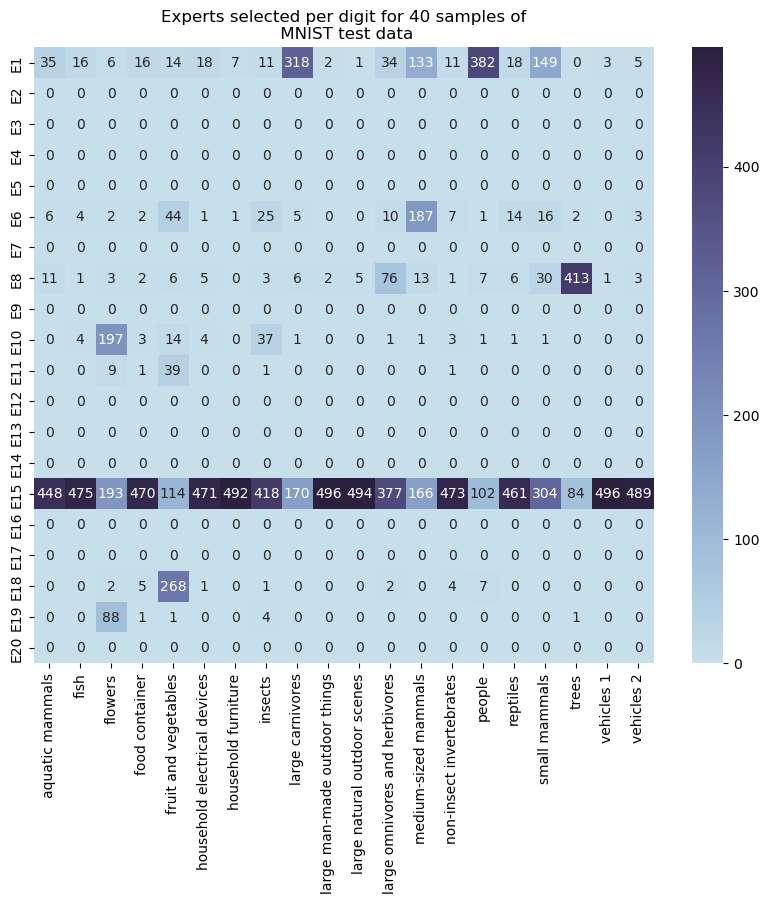

In [40]:
m = 'cifar100_with_reg'
plot_coarse_label_conf_tab(m, w_sample_sim_same=1e-5, w_sample_sim_diff=1e-6)

device cuda:0
Files already downloaded and verified
Files already downloaded and verified
cifar100_with_reg_importance_0.2_100_20_models.pt
Min Training Error 0.408
Mutual Information 4.200
Sample Entropy 1.326
Expert Usage 4.275
cifar100_with_reg_importance_0.2_100_20_models.pt


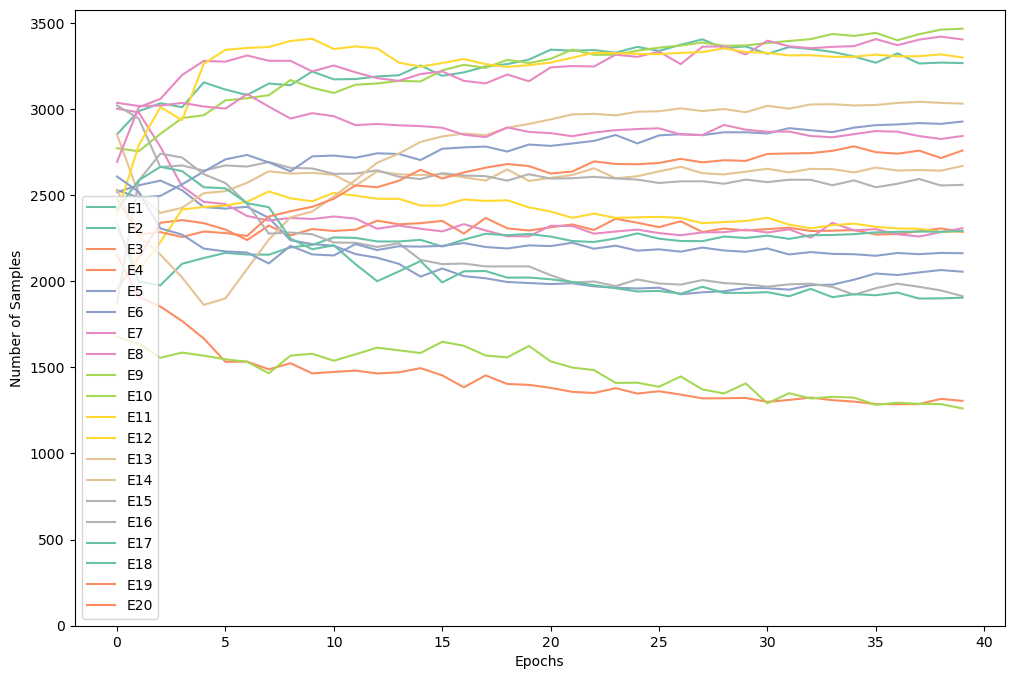

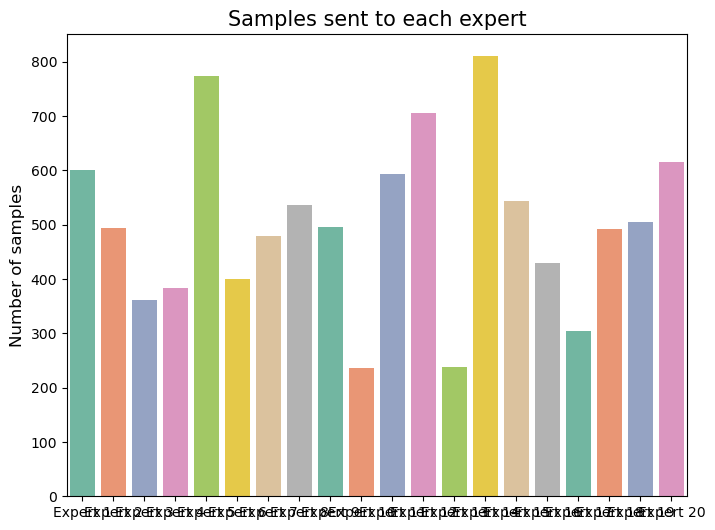

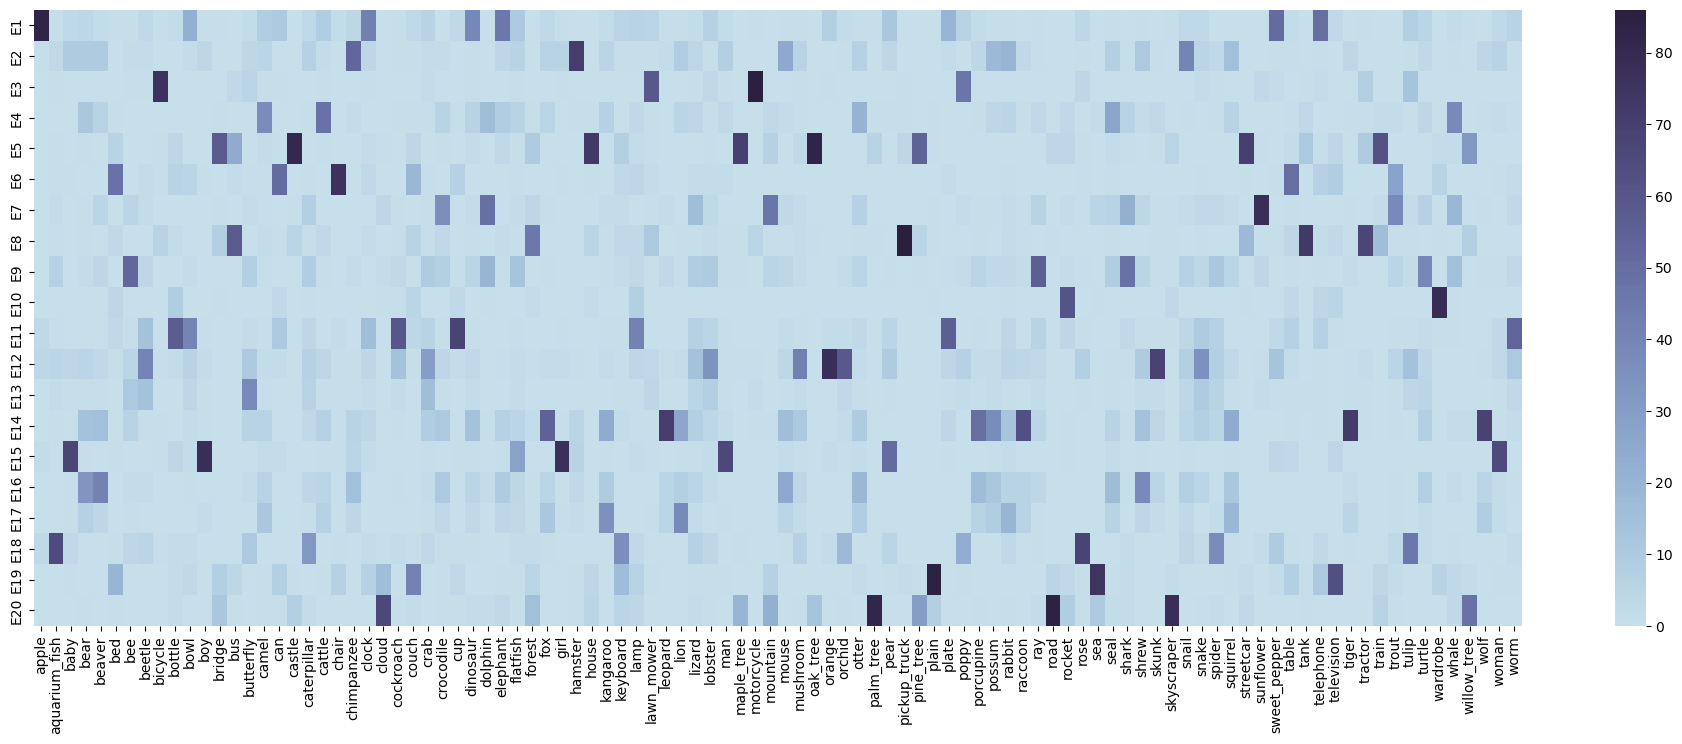


Experts used by the gate for classification of each digit


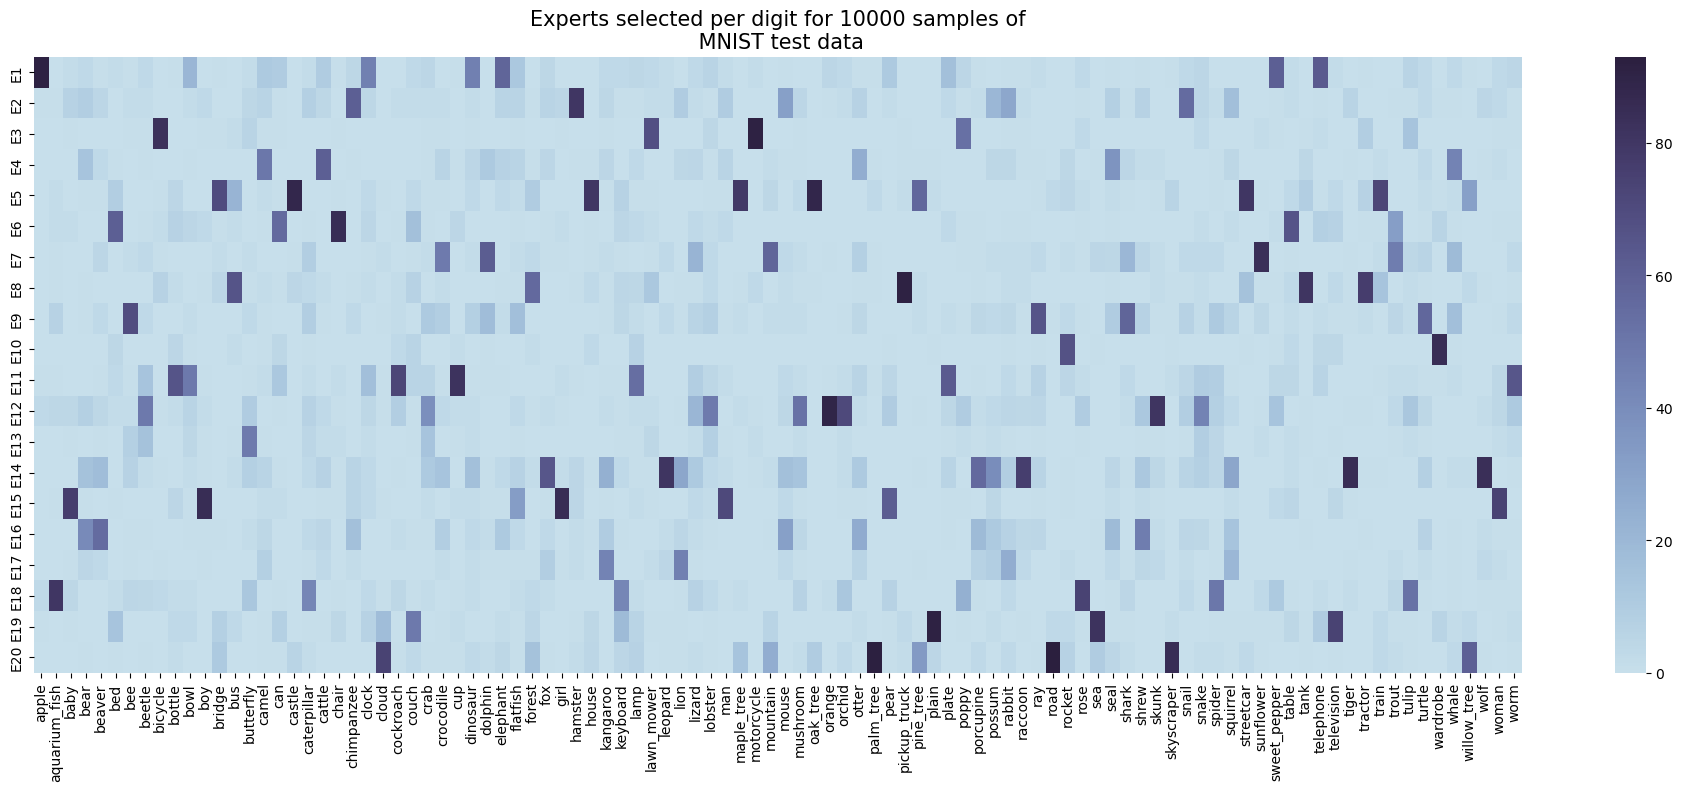

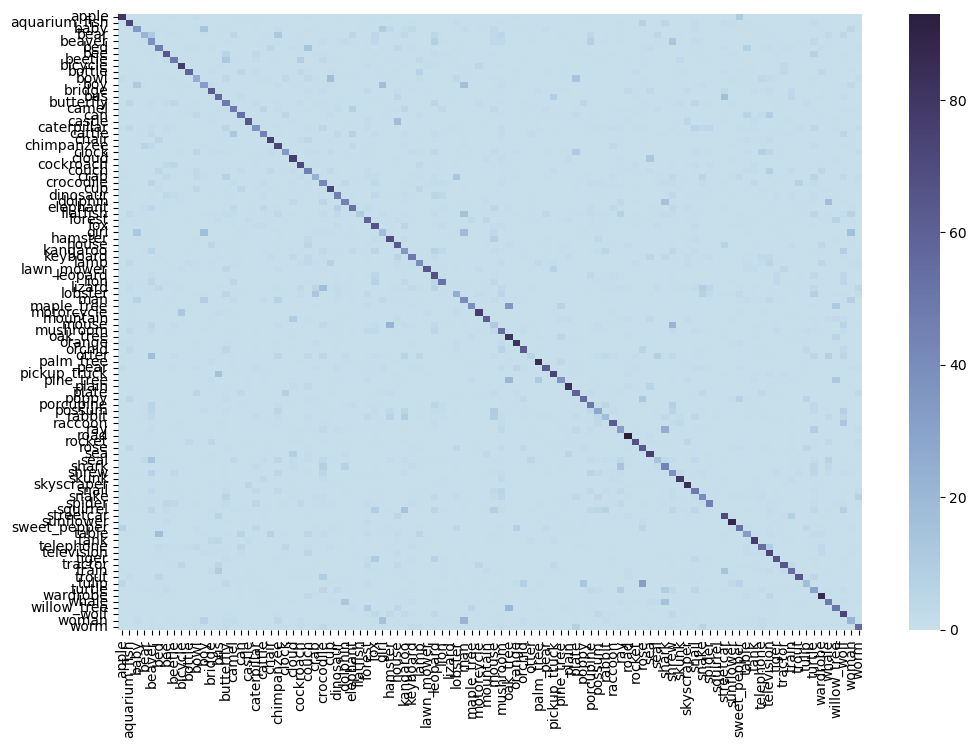

In [27]:
m = 'cifar100_with_reg'
w_importance_range = [0.2]

total_experts = 20
classes = classes_cifar100
num_epochs = 40

test_loader = cifar100_testloader

plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, annot=False,device=device)


Min Training Error 0.410
Mutual Information 2.183
Sample Entropy 0.729
Expert Usage 2.448
cifar100_with_reg_sample_sim_same_0.0001_sample_sim_diff_0.0001_100_20_models.pt


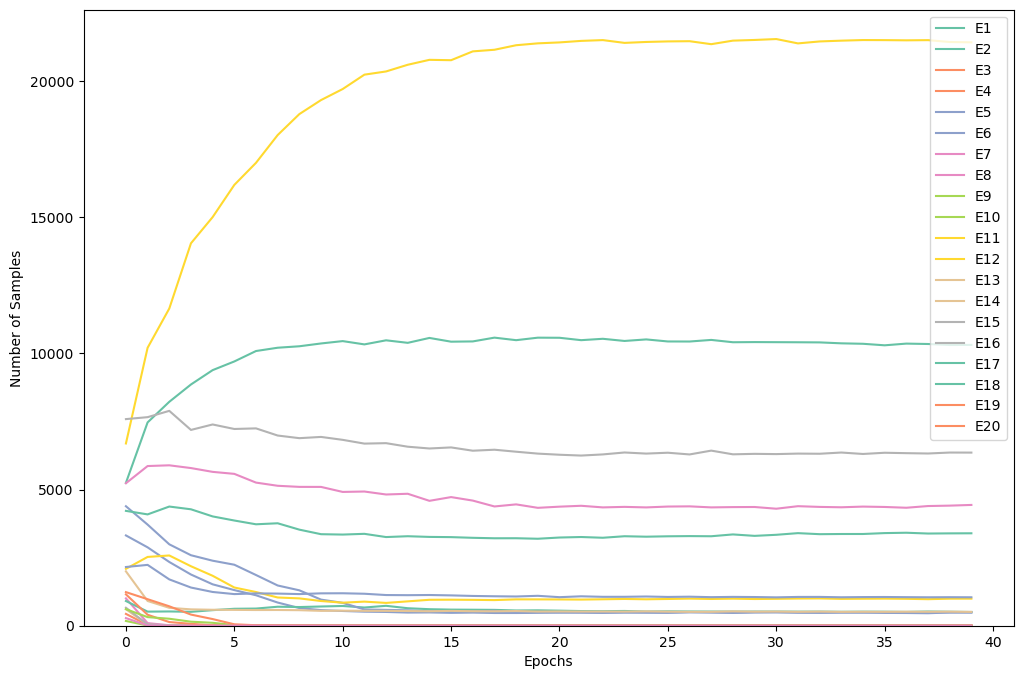

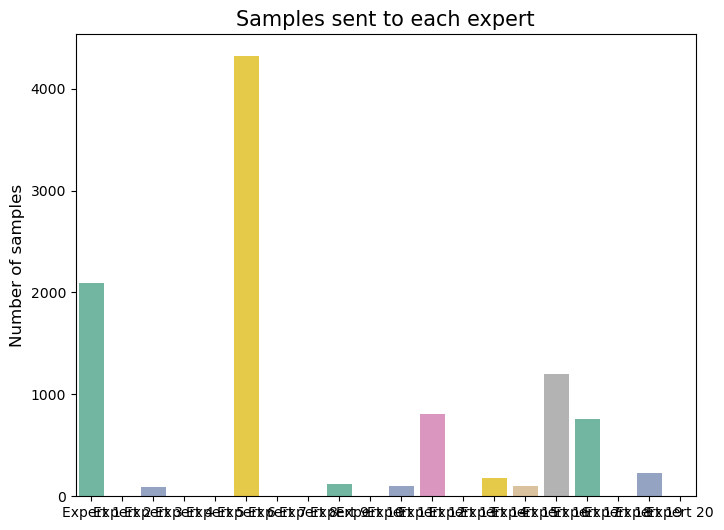

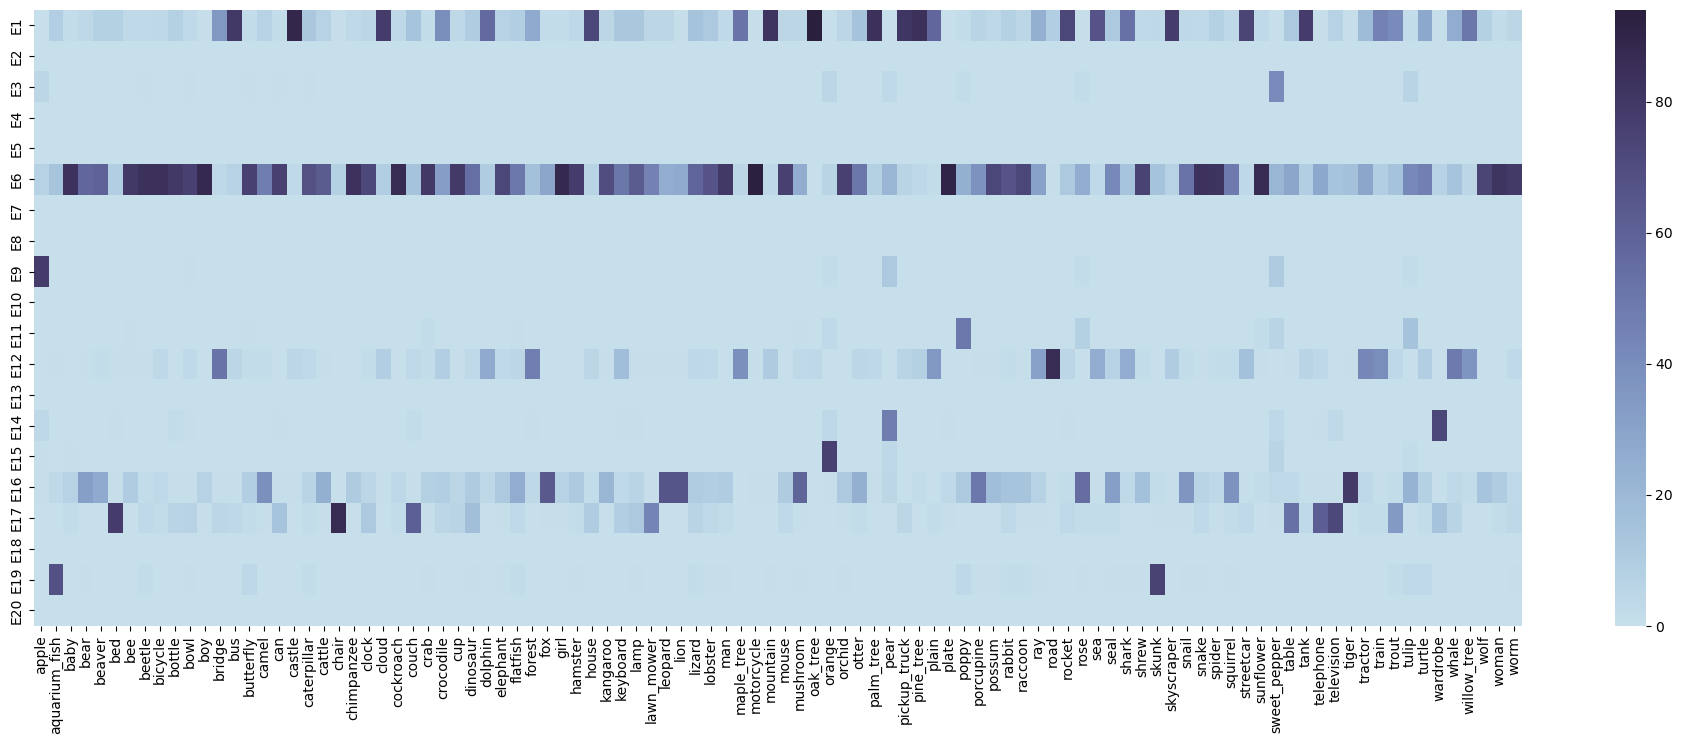


Experts used by the gate for classification of each digit


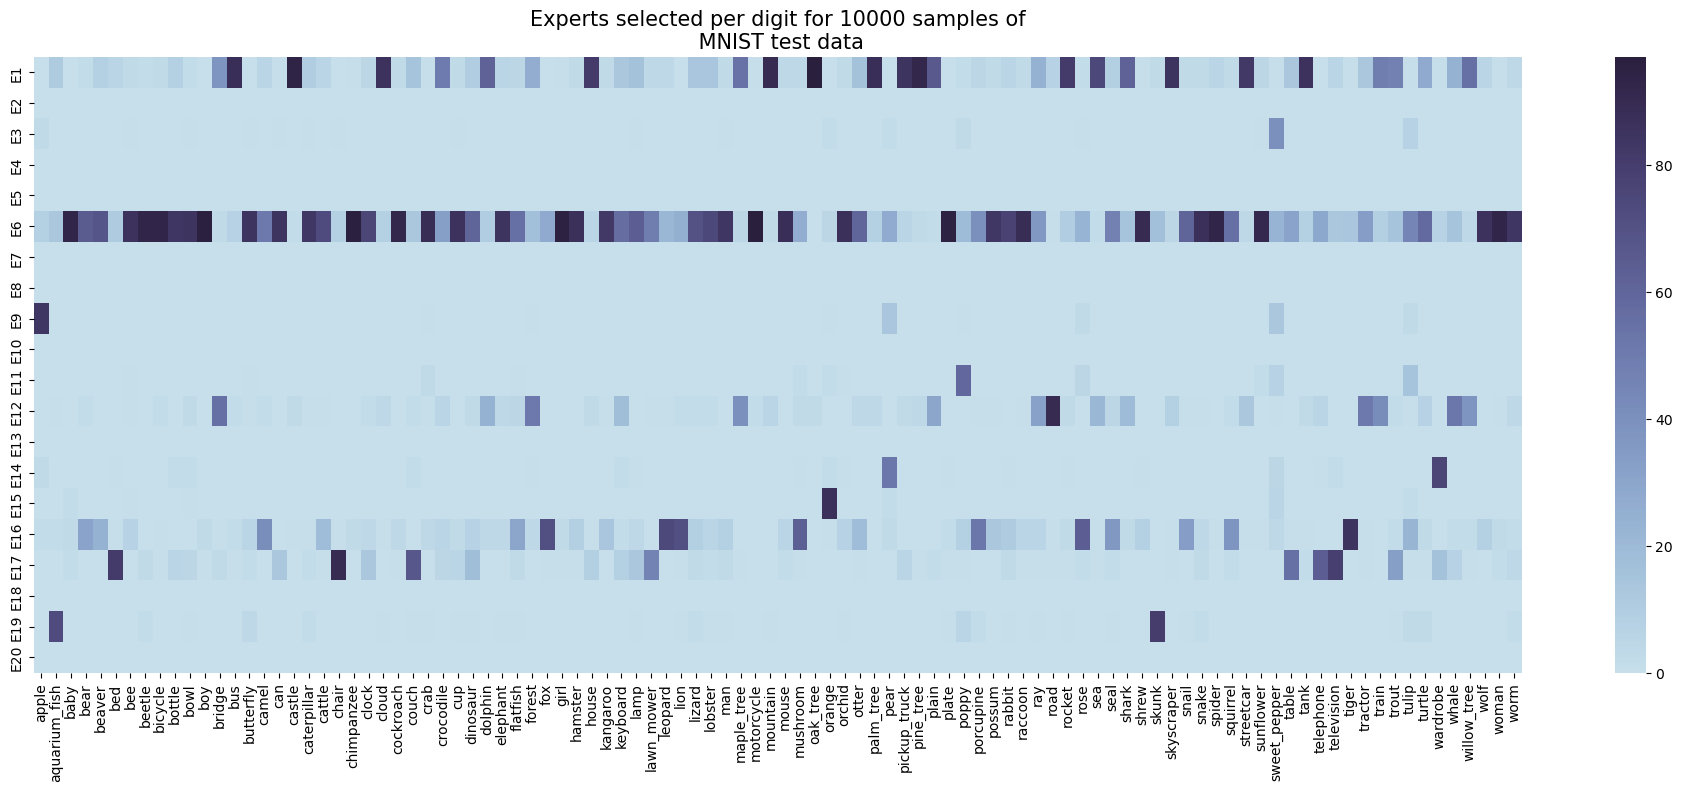

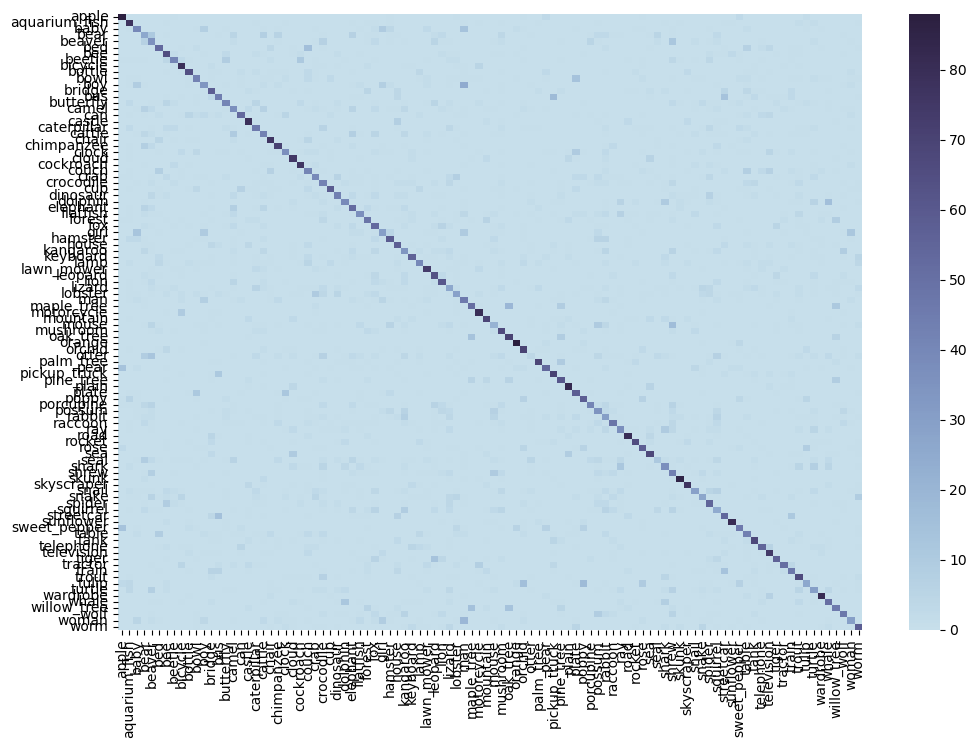

In [31]:
m = 'cifar100_with_reg'
total_experts = 20
classes = classes_cifar100
num_epochs = 40

w_sample_sim_same_range = [1e-4]
w_sample_sim_diff_range = [1e-4]                        

test_loader = cifar100_testloader

plot_expert_usage(m, test_loader, 
                  w_sample_sim_same_range=w_sample_sim_same_range,
                  w_sample_sim_diff_range = w_sample_sim_diff_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, annot=False, device=device)